# Index
- [Storing data to MongoDB](#storing_data_to_mongodb)
- [Reading data from MongoDB](#reading_from_mongodb)
- [Exploratory Data Analysis](#exploratory_data_analysis)
- [Data Pre-processing](#data_Pre-processing)
- [Store and retrieve data through postgres](#store_and_retrieve_data_through_postgres)
- [Data Visualization](#data_visualization)

### Importing Libraries 

In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
from pymongo import MongoClient
import json
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd
import sqlalchemy as db

In [2]:
import warnings
warnings.filterwarnings('ignore')

<a id = "storing_data_to_mongodb"></a>

## Storing data to MongoDB

In [3]:
def read_xml_to_df(file_path):
    # Parse XML data and get root element
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    data = []
    # find the row element which is nested inside another row element
    for outer_row_element in root.findall('.//row'):
        row_data = {}
        for inner_row_element in outer_row_element.findall('.//row'):
            for child_element in inner_row_element:
                row_data[child_element.tag] = child_element.text
            data.append(row_data.copy())

    # Convert the data into dataframe
    return pd.DataFrame(data)



In [4]:
file_path1 = 'Electric Vehicle Population.xml'
file_path2= 'Green House gases data.xml'

In [5]:
df1 = read_xml_to_df(file_path1)
df2 = read_xml_to_df(file_path2)

In [6]:
# function to insert the data into mongo db
def insert_to_mongoDB(url, dataframe, database, collection):

    client = MongoClient(url)

    db = client[database]
    collection = db[collection]

    # Convert DataFrame to JSON
    json_data = dataframe.to_json(orient='records')

    # Insert Data into MongoDB
    data = json.loads(json_data)
    result = collection.insert_many(data)

    # Print confirmation
    if result.inserted_ids:
        print(f"Data inserted successfully")
    else:
        print("Failed to insert data")



In [7]:
mongo_url = 'mongodb://localhost:27017/'
database = 'Washington_State_Department_of_Licensing'
collection1 = 'Electric_Vehicle_Population'
collection2 = 'Green_House_Gases_Emission'
insert_to_mongoDB(mongo_url, df1, database, collection1)
insert_to_mongoDB(mongo_url, df2, database, collection2)

Data inserted successfully
Data inserted successfully


<a id = "reading_from_mongodb"></a>

## Reading data from MongoDB

#### Data is stored in MongoDB. The following function is to retrive data from MongoDB into a dataframe using pandas

In [8]:
# function to retrieve data from mongo db
def retrive_from_mongoDB(url, database, collection):
    client = MongoClient(url) 
    db = client[database]
    collection = db[collection]
    
    # Retrieve data from MongoDB
    cursor = collection.find({})
    data = list(cursor)
    return pd.DataFrame(data)

# Read data from MongoDB 
df_ev = retrive_from_mongoDB(mongo_url, database, collection1)
df_GHG = retrive_from_mongoDB(mongo_url, database, collection2)


<a id = "exploratory_data_analysis"></a>
## Exploratory data analysis

#### ELectric Vehicle Population

In [9]:
# check the top rows for a general understanding of the dataframe
df_ev.head()

,_id,vin_1_10,county,city,state,zip_code,model_year,make,model,ev_type,cafv_type,electric_range,base_msrp,legislative_district,dol_vehicle_id,geocoded_column,electric_utility,_2020_census_tract
0,657f491acd22c48157c72218,2C4RC1N71H,Kitsap,Bremerton,WA,98311,2017,CHRYSLER,PACIFICA,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,33,0,23,349437882,POINT (-122.6466274 47.6341188),PUGET SOUND ENERGY INC,53035091800
1,657f491acd22c48157c72219,2C4RC1N7XL,Stevens,Colville,WA,99114,2020,CHRYSLER,PACIFICA,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,32,0,7,154690532,POINT (-117.90431 48.547075),AVISTA CORP,53065950500
2,657f491acd22c48157c7221a,KNDC3DLCXN,Yakima,Yakima,WA,98908,2022,KIA,EV6,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,14,219969144,POINT (-120.6027202 46.5965625),PACIFICORP,53077000904
3,657f491acd22c48157c7221b,5YJ3E1EA0J,Kitsap,Bainbridge Island,WA,98110,2018,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,215,0,23,476786887,POINT (-122.5235781 47.6293323),PUGET SOUND ENERGY INC,53035091001
4,657f491acd22c48157c7221c,1N4AZ1CP7J,Thurston,Tumwater,WA,98501,2018,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,151,0,35,201185253,POINT (-122.89692 47.043535),PUGET SOUND ENERGY INC,53067011720


In [10]:
# check the number of rows and columns in the dataframe
rows, columns = df_ev.shape
print('Number of rows: ', rows)
print('Number of columns: ', columns)

Number of rows:  159467
Number of columns:  18


In [11]:
# check the columns in the dataframe
df_ev.columns

Index(['_id', 'vin_1_10', 'county', 'city', 'state', 'zip_code', 'model_year',
       'make', 'model', 'ev_type', 'cafv_type', 'electric_range', 'base_msrp',
       'legislative_district', 'dol_vehicle_id', 'geocoded_column',
       'electric_utility', '_2020_census_tract'],
      dtype='object')

In [12]:
# check the info to understand the datatypes and non-null counts of each feature
df_ev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159467 entries, 0 to 159466
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   _id                   159467 non-null  object
 1   vin_1_10              159467 non-null  object
 2   county                159467 non-null  object
 3   city                  159467 non-null  object
 4   state                 159467 non-null  object
 5   zip_code              159467 non-null  object
 6   model_year            159467 non-null  object
 7   make                  159467 non-null  object
 8   model                 159467 non-null  object
 9   ev_type               159467 non-null  object
 10  cafv_type             159467 non-null  object
 11  electric_range        159467 non-null  object
 12  base_msrp             159467 non-null  object
 13  legislative_district  159467 non-null  object
 14  dol_vehicle_id        159467 non-null  object
 15  geocoded_column  

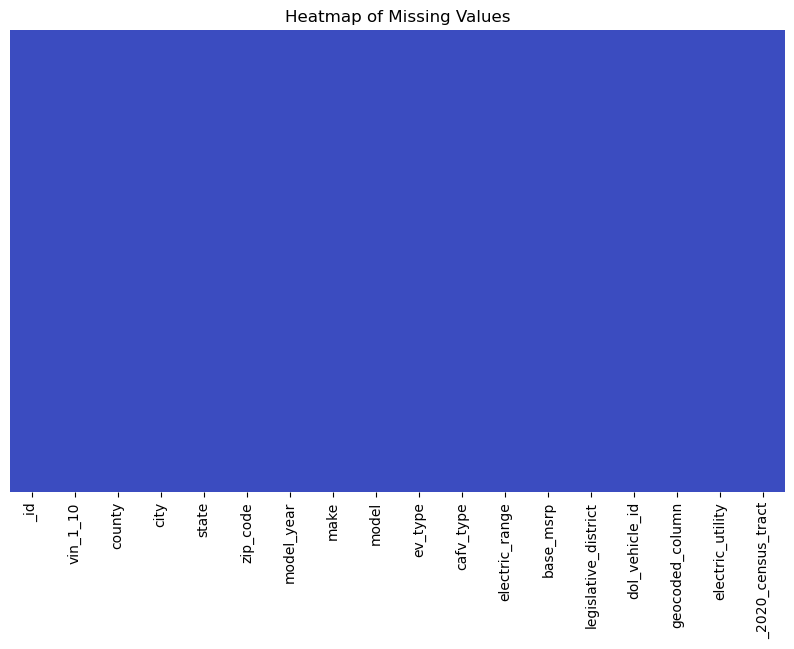

In [13]:
# check for missing values in the dataframe using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_ev.isnull(), cmap='coolwarm', cbar=False, yticklabels=False)
plt.title('Heatmap of Missing Values')
plt.show()

There does not seem to be missing values in any features. It can be confirmed by printing the sum of rows with missing values for all the features.

In [14]:
# check for missing values
df_ev.isnull().sum()

_id                     0
vin_1_10                0
county                  0
city                    0
state                   0
zip_code                0
model_year              0
make                    0
model                   0
ev_type                 0
cafv_type               0
electric_range          0
base_msrp               0
legislative_district    0
dol_vehicle_id          0
geocoded_column         0
electric_utility        0
_2020_census_tract      0
dtype: int64

In [15]:
# check for any duplicate rows in the dataframe
df_ev.duplicated().sum()

0

There are no missing values or duplicates in the dataframe.